In [15]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import re


In [16]:
def perform_preprocessing(train_dataframe, test_dataframe):
    merged_dataset = [train_dataframe, test_dataframe]

    deck_ship = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
    ports_ship = {"S": 0, "C": 1, "Q": 2}
    genders = {"male": 0, "female": 1}
    
    mean_age = train_dataframe["Age"].mean()
    std_age = test_dataframe["Age"].std()
    
    
    for dataset in merged_dataset:
        
        dataset["p_relatives"] = dataset["SibSp"] + dataset["Parch"]
        dataset.loc[dataset["p_relatives"] > 0, "individual"] = 0
        dataset.loc[dataset["p_relatives"] == 0, "individual"] = 1
        dataset["individual"] = dataset["individual"].astype(int)
        
        
        dataset["Cabin"] = dataset["Cabin"].fillna("U0")
        dataset["Deck_Pos"] = dataset["Cabin"].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
        dataset["Deck_Pos"] = dataset["Deck_Pos"].map(deck_ship)
        dataset["Deck_Pos"] = dataset["Deck_Pos"].fillna(0)
        dataset["Deck_Pos"] = dataset["Deck_Pos"].astype(int)
        
        
        is_null = dataset["Age"].isnull().sum()
        rand_age_to_fill = np.random.randint(mean_age - std_age, mean_age + std_age, size = is_null)
        age_column_copy = dataset["Age"].copy()
        age_column_copy[np.isnan(age_column_copy)] = rand_age_to_fill
        dataset["Age"] = age_column_copy
        dataset["Age"] = train_dataframe["Age"].astype(int)
        
        
        dataset["Embarked"] = dataset["Embarked"].fillna("S")
        dataset["Embarked"] = dataset["Embarked"].map(ports_ship)
        
        dataset["Sex"] = dataset["Sex"].map(genders)
        
        dataset["Fare"] = dataset["Fare"].fillna(0)
        dataset["Fare"] = dataset["Fare"].astype(int)
        
    
    train_dataframe["Age"].isnull().sum()
    merged_dataset = [train_dataframe, test_dataframe]
    
    for dataset in merged_dataset:
        #divide Age into Age Groups
        dataset.loc[ dataset["Age"] <= 10, "Age"] = 0
        dataset.loc[(dataset["Age"] > 10) & (dataset["Age"] <= 20), "Age"] = 1
        dataset.loc[(dataset["Age"] > 20) & (dataset["Age"] <= 30), "Age"] = 2
        dataset.loc[(dataset["Age"] > 30) & (dataset["Age"] <= 40), "Age"] = 3
        dataset.loc[(dataset["Age"] > 40) & (dataset["Age"] <= 50), "Age"] = 4
        dataset.loc[(dataset["Age"] > 50) & (dataset["Age"] <= 60), "Age"] = 5
        dataset.loc[ dataset["Age"] > 60, 'Age'] = 6
        
        #divide Fare into Fare Groups
        dataset.loc[ dataset["Fare"] <= 8, "Fare"] = 0
        dataset.loc[(dataset["Fare"] > 8) & (dataset["Fare"] <= 15), "Fare"] = 1
        dataset.loc[(dataset["Fare"] > 15) & (dataset["Fare"] <= 40), "Fare"]   = 2
        dataset.loc[(dataset["Fare"] > 40) & (dataset["Fare"] <= 100), "Fare"]   = 3
        dataset.loc[(dataset["Fare"] > 100) & (dataset["Fare"] <= 250), "Fare"]   = 4
        dataset.loc[ dataset["Fare"] > 250, "Fare"] = 5
    
    
    train_dataframe = train_dataframe.drop(["SibSp"], axis=1)
    test_dataframe = test_dataframe.drop(["SibSp"], axis=1)
    
    train_dataframe = train_dataframe.drop(["Parch"], axis=1)
    test_dataframe = test_dataframe.drop(["Parch"], axis=1)
    
    train_dataframe = train_dataframe.drop(["p_relatives"], axis=1)
    test_dataframe = test_dataframe.drop(["p_relatives"], axis=1)
    
    train_dataframe = train_dataframe.drop(["PassengerId"], axis=1)
    test_dataframe = test_dataframe.drop(["PassengerId"], axis=1)
    
    train_dataframe = train_dataframe.drop(["Cabin"], axis=1)
    test_dataframe = test_dataframe.drop(["Cabin"], axis=1)
    
    train_dataframe = train_dataframe.drop(["Name"], axis=1)
    test_dataframe = test_dataframe.drop(["Name"], axis=1)
    
    train_dataframe = train_dataframe.drop(["Ticket"], axis=1)
    test_dataframe = test_dataframe.drop(["Ticket"], axis=1)
    
    train_dataframe["Survived"].replace([0,1], [-1,1], inplace=True)
    test_dataframe["Survived"].replace([0,1], [-1,1], inplace=True)

    return train_dataframe,test_dataframe



In [17]:
def decisition_tree_classifier(Y_train, X_train, Y_test, X_test, model):
    model.fit(X_train,Y_train)
    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)
    
    Y_train = np.array(Y_train)
    Y_test = np.array(Y_test)
    
    error_train_prediction = calculate_error_rate(prediction_train,Y_train)
    error_test_prediction = calculate_error_rate(prediction_test,Y_test)
    
    return error_train_prediction,error_test_prediction


def decisition_tree_classifier_adaboost(Y_train, X_train, Y_test, X_test,iteration, decision_tree_model):
    length_train_samples = len(X_train)
    length_test_samples = len(X_test)
    
    weights = np.ones(length_train_samples) / length_train_samples
    prediction_train = np.zeros(length_train_samples)
    prediction_test = np.zeros(length_test_samples)
    
    Y_temp = np.array(Y_train)
    Y_test = np.array(Y_test)

    for i in range(iteration):
        decision_tree_model.fit(X_train, Y_train, sample_weight = weights)
        train_prediction_iteration = decision_tree_model.predict(X_train)
        test_prediction_iteration = decision_tree_model.predict(X_test)
        
        miss = [int(wrong_prediction) for wrong_prediction in (train_prediction_iteration != Y_temp)]

        error_miss = np.dot(weights,(train_prediction_iteration != Y_temp))/sum(weights)
        
        alpha_miss = 0.5 * np.log( (1- error_miss )/ float(error_miss) )

        weights = np.array(np.multiply(weights, np.exp(-alpha_miss * train_prediction_iteration * Y_temp )))

        prediction_train = [sum(prediction) for prediction in zip(prediction_train,\
                                                [prediction * alpha_miss for prediction in train_prediction_iteration])]
        
        prediction_test = [sum(prediction) for prediction in zip(prediction_test,\
                                                 [prediction * alpha_miss for prediction in test_prediction_iteration])]
        
    prediction_train, prediction_test = np.sign(prediction_train),np.sign(prediction_test)
    
    error_train_prediction = calculate_error_rate(prediction_train,Y_train)
    error_test_prediction = calculate_error_rate(prediction_test,Y_test)
    
    return error_train_prediction,error_test_prediction,prediction_test

def calculate_error_rate(prediction, ground_truth):
    return sum(prediction != ground_truth) / float(len(prediction))

def calculate_accuracy(ground_truth, predicted):
    correct_prediction = 0
    for i in range(len(ground_truth)):
        if ground_truth[i] == predicted[i]:
            correct_prediction = correct_prediction + 1
    return correct_prediction / float(len(ground_truth)) * 100.0

def plot_adaboost_error_rate(error_train, error_test):
    errors_dataframe = pd.DataFrame([error_train, error_test]).T
    errors_dataframe.columns = ['Training_error', 'Testing_error']
    plot_graph = errors_dataframe.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot_graph.set_xlabel('Number of Rounds', fontsize = 12)
    plot_graph.set_xticklabels(range(0,500,100))
    plot_graph.set_ylabel('Error rate', fontsize = 12)
    plot_graph.set_title('Error rate vs Number of Rounds', fontsize = 16)
    plot_graph.axhline(y=error_test[0], linewidth=1, color = 'red', ls = 'dashed')

Accuracy: 92.584%


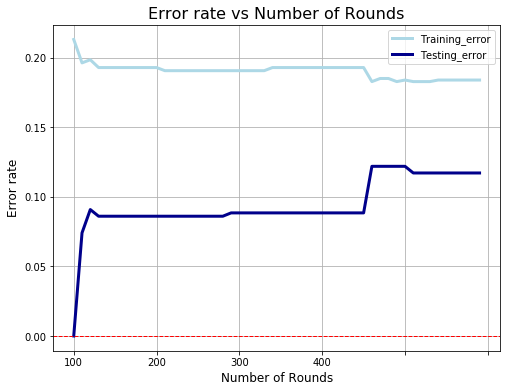

In [18]:
train_dataframe = pd.read_csv("train.csv")
test_dataframe = pd.read_csv("test.csv")
Y_test = pd.read_csv("gender_submission.csv")
test_dataframe = pd.merge(test_dataframe, Y_test, on=['PassengerId'])
train_dataframe, test_dataframe = perform_preprocessing(train_dataframe,test_dataframe)

X_train = train_dataframe.drop("Survived", axis = 1)
Y_train = train_dataframe["Survived"]
X_test = test_dataframe.drop("Survived", axis = 1)
Y_test = test_dataframe["Survived"]

decision_tree_model = DecisionTreeClassifier(max_depth = 1)
error_decision_tree = decisition_tree_classifier(Y_train, X_train, Y_test, X_test, decision_tree_model)



error_train, error_test = [error_decision_tree[0]], [error_decision_tree[1]]

accuracy = []
    
iteration_range = range(10, 500, 10)
for iteration in iteration_range:    
    error_decision_tree_adaboost = decisition_tree_classifier_adaboost(Y_train, X_train, Y_test, X_test,\
                                                                           iteration, decision_tree_model)
    error_train.append(error_decision_tree_adaboost[0])
    error_test.append(error_decision_tree_adaboost[1])
    prediction_test = error_decision_tree_adaboost[2]
    accuracy_pred = calculate_accuracy(Y_test,prediction_test)
    accuracy.append(accuracy_pred)
    
plot_adaboost_error_rate(error_train, error_test)

print("Accuracy: %.3f%%" % max(accuracy))
